The on-site energies $\left\{ E_{i} \right\}$ are taken as independent random variables each uniformly distributed in the interval $[-W/2, W/2]$:

\begin{equation}
    \rho(E) = \frac{1}{W} \Theta\left(\frac{W}{2} - \lvert E \rvert \right)
\end{equation}

The Hamiltonian

\begin{equation}
    H = - \sum_{\langle i, j \rangle} (c_{i}^{\dagger} c_{j} + c_{j}^{\dagger} c_{i}) + \sum_{i = 1}^{N} E_{i} c_{i}^{\dagger} c_{i}
\end{equation}

set on a Cayley tree can be analytically solved and led to the confirmation of Anderson’s conjecture that loops in high dimensions are not crucial for localizing the electrons.

As a matrix, $H$ can be seen as the sum of the (negative) adjacency matrix and a diagonal matrix with entries $\left\{ E_{1}, \dots, E_{N} \right\}$, i.e.

\begin{equation}
    H_{i j} = - A_{i j} + E_{i} \delta_{i j}
\end{equation}

### Inputs

* To create the Hamiltonian
    * Linear size $N$.
    * Mean connectivity $c$.
    * Disorder value $W$.

1. Create the Hamiltonian.
    1. Create a random vector of size $N$ from a uniform distribution $[-W/2, W/2]$.
    1. Transform the above vector into a diagonal matrix.
    1. Create a random regular graph of size $N \times N$ and mean connectivity $c$.
    1. Obtain the adjacency matrix of the above RRG.
    1. Take the difference to create the Hamiltonian.

### To Do:

Check difference in performance between:
1. Using two arrays and waiting to update all of the values before making the old values the new ones.
1. Update the values in place.

In [10]:
using LinearAlgebra
using Distributions
using ProgressMeter
using LightGraphs
using Random
using Plots

In [11]:
get_energies(N, W) = rand(Uniform(-W/2., W/2.), N)
get_adjacency(N, c) = adjacency_matrix(random_regular_graph(N, c))


function direct_diagonalization(E, A)
    H = Symmetric(Matrix(Diagonal(E) - A))
    λ_values = eigvals(H)
    
    return λ_values
end


function make_ids_array(A)
    # List positions of neighbors for cavity precisions
    
    N = A.n  # Linear size.
    ids_array = []
    
    for j in 1:N
        j_neighbors = [k for k in A[j, :].nzind]

        for k in j_neighbors
            positions = [(k-1)*c + sum(A[k, 1:l]) for l in A[k, :].nzind if l != j]
            push!(ids_array, positions)
        end
    end
    
    return ids_array
end


function cavity_method(E, A, ϵ, λ_range; tolerance=1e-6, max_iter=3000)
    
    # List positions of neighbors for cavity precisions.
    ids_array = make_ids_array(A)
    Ek_values = E[A.rowval]
    
    points = length(λ_range)  
    ρ_values = zeros(points)  # Spectral density values.
    
    # Initial cavity precisions. 
    # For values after the first λ, use previous result.
    ω = rand(Complex{Float64}, N*c)
    
    @showprogress for i in 1:points
        λ = λ_range[i]
        z = ϵ + im*λ
        
        z_array = z .- im*Ek_values
        
        # Update cavity precisions to reach fixed point.
        for iter in 1:max_iter
            n_sum = [sum(1. ./ ω[ids]) for ids in ids_array]
            ω_new = z_array + n_sum
            Δω = maximum(abs.(ω_new - ω))
            ω = ω_new
            (Δω < tolerance) && break
            (iter == max_iter) && println("Above tolerance: λ = $(λ)")
        end
        
        
        # Compute the marginal precisions.
        cavity_ω = reshape(ω, (c, N))
        margin_ω = z .+ (-im*E + sum(1 ./ cavity_ω, dims=1)[1, :])
        
        # Compute ρ(λ)
        ρ = imag(sum(im ./ margin_ω)) / (π * N)
        ρ_values[i] = ρ
    end
    
    return ρ_values
end

cavity_method (generic function with 1 method)

In [12]:
Random.seed!(42)

N = 2^10
W = 0.3
c = 3
ϵ = 0.001
points = 150
λ_range = range(0, 3, length=points)

E = get_energies(N, W)
A = get_adjacency(N, c)
λ_vals = direct_diagonalization(E, A)
ρ_vals = cavity_method(E, A, ϵ, λ_range);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


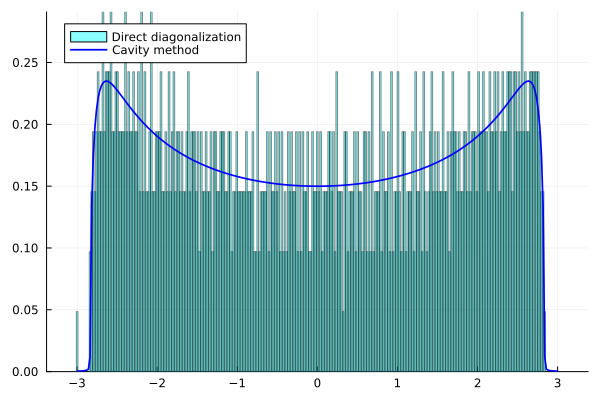

In [13]:
Δλ = λ_range.step.hi
bin_λ = [-λ - (Δλ/2) for λ in reverse(λ_range)]
append!(bin_λ, -reverse(bin_λ))


# Complete spectral density values of the cavity 
# method for negative λ by using ρ(-λ) = ρ(λ).

λ_xplot = [-λ for λ in reverse(λ_range)]
append!(λ_xplot, λ_range)

ρ_yplot = reverse(ρ_vals)
append!(ρ_yplot, ρ_vals)


####################
# Initialize plot. #
####################

cavity_plot = histogram(λ_vals, label="Direct diagonalization",
                        normalize=:pdf, 
                        bins=bin_λ, 
                        alpha=0.45, 
                        color=:aqua)

# ρ(λ) via cavity method.
plot!(λ_xplot, ρ_yplot, label="Cavity method", color=:blue, lw=1.7)